# Bayesian Parameter Estimation of a Neural Tuning Curve - Demystifying Nested Sampling for Bayesian Inference

This notebook performs Bayesian inference on simulated neural tuning data using **nested sampling via PyMultiNest**. *Nested sampling* is a powerful technique for Bayesian inference and model comparison. 

Rather than using PyMultiNest directly, I will first build an intuitive understanding of how nested sampling works by implementing a simplified version from scratch. I will:
- load the neural tuning curve dataset,
- provide a theoretical explanation of nested sampling,
- build a pedagogical implementation to illustrate the algorithm,
- show how real nested sampling is applied via PyMultiNest,
- analyze the outcomes and interpret the posterior distributions to assess uncertainty and parameter identifiability.

References:
- for neural tuning: Dayan, P., & Abbott, L. F. (2001). Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems. MIT Press;
- for nested sampling and pymultinest: Buchner et al. 2014, A&A.

# Bayesian Inference and Nested Sampling

In Bayesian inference, we aim to estimate the **posterior distribution** $ P(\theta \mid d) $  of model parameters $ \theta $, given observed data $ d $, a likelihood function $ P(d \mid \theta) $, and a prior distribution $ P(\theta) $.
The posterior is given by Bayes’ theorem:

$$
P(\theta \mid d) = \frac{P(d \mid \theta) \, P(\theta)}{P(d)} 
$$
where $  P(d) $, also named $Z$, is the **Bayesian evidence** (also known as the **marginal likelihood**) and it is expressed as:
$$
P(d) = \int P(d \mid\theta) \, P(\theta) \, d\theta = \int \mathcal{L}(\theta)\, P(\theta)\, d\theta
$$

The evidence is the normalization constant of the posterior, but it is also what allows us to compute **Bayes factors** between models for model comparison.
However, this high-dimensional integral is often computationally intractable.



## Nested Sampling: Conceptual Overview

**Nested sampling** is a Monte Carlo algorithm specifically designed to compute the evidence $ Z $, while also providing samples from the posterior distribution as a byproduct.

Rather than sampling from the posterior directly (like MCMC), nested sampling works by sampling uniformly from the prior, keeping only points with likelihood above a threshold and iteratively increasing the threshold, while estimating how much prior volume is left.


At high-level, the steps of nested sampling are:
1. initialize with $ N $ “live” points drawn from the prior,
2. at each iteration:
   - find the point with the lowest likelihood among the live points,
   - replace it with a new sample from the prior, constrained to have higher likelihood,
   - estimate the fraction of remaining prior volume $ X_i $,
   - accumulate contribution to the evidence:

     $$
     Z \approx \sum_i \mathcal{L}_i \cdot \mathcal{w}_i, \,\, \rm{where} \,\,  \mathcal{w}_i = X_{i-1} - X_i 
     $$


3. stop when the remaining volume is negligible or the evidence has converged.





At each iteration, the remaining prior volume shrinks approximately exponentially:

$$
X_i = e^{-i / N}
$$

This gives us a sense of how nested sampling explores smaller and smaller regions of higher likelihood over time.



Nested sampling excels in problems where the posterior is multimodal, non-Gaussian, or exhibits strong degeneracies. Libraries such as PyMultiNest offer powerful and efficient implementations, but understanding the algorithm’s core logic helps highlight its strengths and limitations.

# Toy Implementation of Nested Sampling

In the next section, I implement a simplified version of nested sampling to illustrate how it works.
I implement a 2D version using a Gaussian likelihood defined over a unit square prior space $[0, 1] \times [0, 1]$.


Nested sampling follows a clear geometric idea: it starts with random samples from the prior, then iteratively removes the worst (lowest-likelihood) point and replaces it with a new one that has a higher likelihood, effectively shrinking the volume of the prior space it explores.

This implementation helps visualize that process in an intuitive way. It shows:
- the initial sample of “live points” spread over the entire prior,
- how the cloud of live points shrinks inward toward the peak of the likelihood function,
- the progressive concentration of probability mass in high-likelihood regions.

Each iteration mimics the key behavior of nested sampling: rejecting low-likelihood regions and refining the posterior.


While this version is simplified and operates in 2D with a fixed likelihood function, the fundamental logic mirrors that of PyMultiNest and other nested sampling algorithms:
- real nested sampling tracks prior volume shrinkage and estimates evidence $ Z $,
- it handles high-dimensional and multimodal posteriors,
- PyMultiNest uses ellipsoidal approximations to speed up constrained sampling.

This example captures the core behavior of the algorithm and provides a mental model on how nested sampling works.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Likelihood function: 2D Gaussian bump ----
def likelihood(x, y):
    return np.exp(-((x - 0.5)**2 + (y - 0.5)**2) / (2 * 0.05**2))

# ---- Prior: Uniform over [0, 1] x [0, 1] ----
def sample_prior(n):
    return np.random.uniform(0, 1, size=(n, 2))

# ---- Nested sampling parameters ----
n_live = 100
n_iterations = 200

# ---- Initialize live points ----
live_points = sample_prior(n_live)
likelihoods = np.array([likelihood(x, y) for x, y in live_points])

# ---- Store history for plotting ----
all_live_points = [live_points.copy()]

# ---- Nested sampling loop (toy version) ----
for i in range(n_iterations):
    # Find worst point
    worst_idx = np.argmin(likelihoods)
    worst_L = likelihoods[worst_idx]

    # Remove and replace with better point
    while True:
        candidate = sample_prior(1)[0]
        cand_L = likelihood(candidate[0], candidate[1])
        if cand_L > worst_L:
            live_points[worst_idx] = candidate
            likelihoods[worst_idx] = cand_L
            break

    # Store for visualization
    all_live_points.append(live_points.copy())


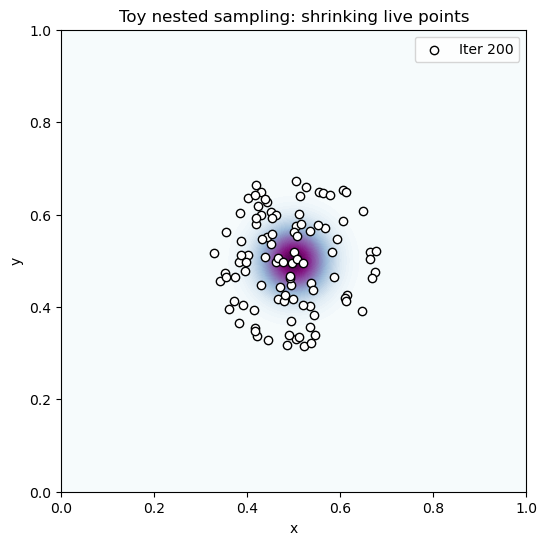

In [2]:
from IPython.display import clear_output
from matplotlib import cm

# ---- Create grid for background likelihood map ----
xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
zz = likelihood(xx, yy)

fig, ax = plt.subplots(figsize=(6, 6))

for i, points in enumerate(all_live_points[::5]):
    clear_output(wait=True)
    ax.clear()
    ax.contourf(xx, yy, zz, levels=50, cmap=cm.BuPu)
    ax.scatter(points[:, 0], points[:, 1], c='white', edgecolor='black', label=f"Iter {i*5}")
    ax.set_title("Toy nested sampling: shrinking live points")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    display(fig)
    plt.pause(0.2)

plt.close()


# Nested sampling for Parameter Estimation of a Neural Tuning Curve
In this section, I run a real nested sampling inference using PyMultiNest on the neural tuning curve data.

The algorithm estimates the parameters of a Gaussian tuning curve commonly used in systems neuroscience to describe neuronal orientation selectivity:

$$
f(s) = r_{\rm max} \, \exp\left(-\frac{(s - s_{\rm max})^2}{2\sigma_f^2}\right) + \varepsilon
$$
where $\varepsilon$ represents the noise in the data. The parameters are:
- $ r_{\rm max}$: peak firing rate,
- $ s_{\rm max} $: preferred stimulus orientation,
- $ \sigma_f $: tuning width.

More background can be found in the notebook "simulation.ipynb"

## Data loading 
This section loads the dataset generated in simulation.ipynb.

If the file is not found, simulation.py is executed automatically to generate the data and file.

In [3]:
import os
import numpy as np
import pandas as pd


# Load data
csv_file = "tuning_data.csv"

if not os.path.exists(csv_file):
    from simulation import simulate_tuning_data
    df = simulate_tuning_data()
else:
    df = pd.read_csv(csv_file)

s = df["s"].values 
response = df["response"].values
error = df["error"].values


## Run nested sampling
PyMultiNest uses a C++ backend with OpenMP for parallelization. In some environments (especially Jupyter notebooks), it may spawn more threads than the system can handle, which can lead to excessive memory usage or even crashes.
To avoid these issues, the model fitting code is moved to a separate script (run_pymultinest_fit.py) and executed from the terminal instead of running it directly in the notebook.

In [4]:
import subprocess

# Run the fitting script
subprocess.run(["python", "run_pymultinest_fit.py"])

# Load posterior samples
posterior_samples = np.load("posterior_samples.npy")


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.996377
Replacements:                                550
Total Samples:                               552
Nested Sampling ln(Z):              -3722.626729
Importance Nested Sampling ln(Z):    -133.633990 +/-  0.999094
Acceptance Rate:                        0.981997
Replacements:                                600
Total Samples:                               611
Nested Sampling ln(Z):              -3157.507865
Importance Nested Sampling ln(Z):    -133.735256 +/-  0.998898
Acceptance Rate:                        0.958702
Replacements:                                650
Total Samples:                               678
Nested Sampling

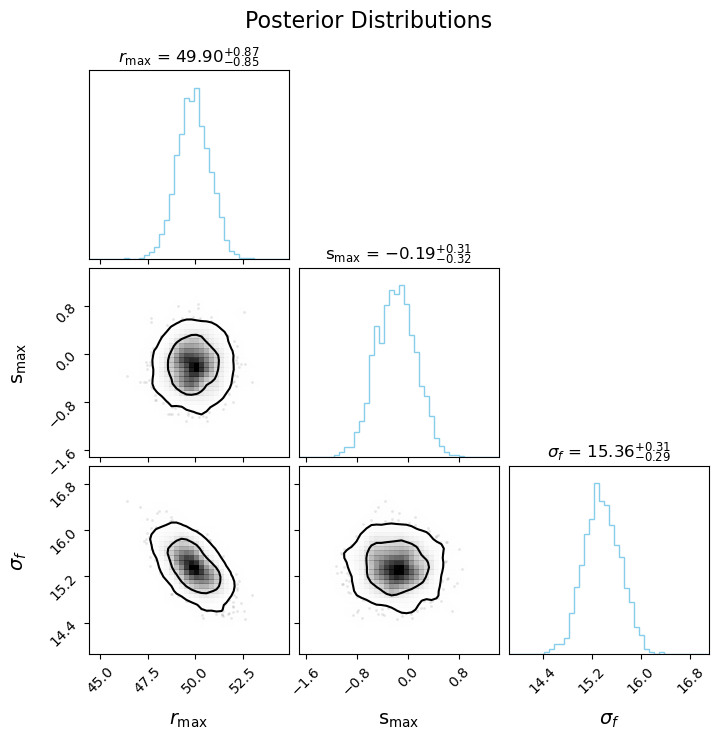

In [5]:
import corner
import numpy as np
import matplotlib.pyplot as plt


posterior_samples = np.load("posterior_samples.npy")
posterior_samples = posterior_samples[:, :3]


# Compute min/max for plotting
mins = posterior_samples.min(axis=0)
maxs = posterior_samples.max(axis=0)

# Add 30% buffer to plot ranges
plot_range = []
for min_val, max_val in zip(mins, maxs):
    delta = max_val - min_val
    buffer = 0.3 * delta
    plot_range.append((min_val - buffer, max_val + buffer))

# Plot the corner plot
fig = corner.corner(
    posterior_samples,
    labels=[r"$r_{\rm max}$", r"s$_{\rm max}$", r"$\sigma_f$"],
    #truths=[52, 0, 15],
    range=plot_range,
    bins=40,
    smooth=1.0,
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    hist_kwargs={"color": "skyblue"},
    plot_datapoints=True,
    levels=(0.68, 0.95),
)

fig.subplots_adjust(top=0.9)
fig.suptitle("Posterior Distributions", fontsize=16)
plt.show()

The corner plot above shows marginal and joint posterior distributions for the model parameters.
The diagonal plots are the marginal distributions for each parameter individually.
The off-diagonal plots show the joint distributions (2D projections) for every pair of parameters.
The shaded contours represent regions containing 68% and 95% of the posterior probability.
The blue histograms show the distribution of the computed values, given the data.

The posteriors are:
- narrow and concentrated (high certainty),
- nearly uncorrelated, meaning the parameters are fairly identifiable in this model.

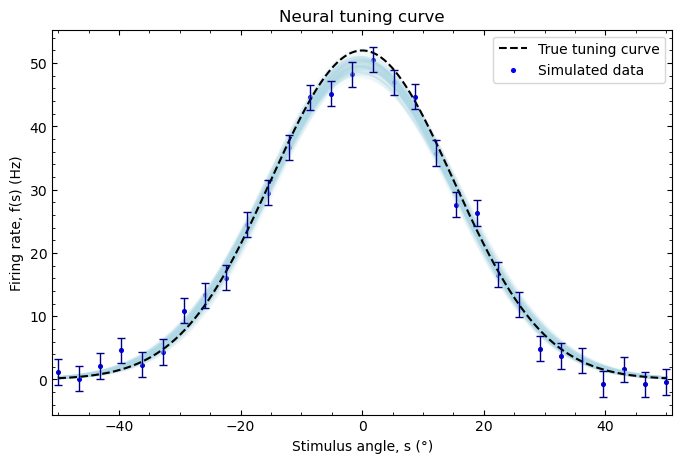

In [6]:
# Plot 100 random posterior samples
from simulation import tuning_curve
import matplotlib.ticker as ticker


s_c = np.linspace(-50, 50, 500)

fig, ax = plt.subplots(figsize=(8, 5))

# Plot 100 sampled curves
for i in range(100):
    r_i, s_i, sigma_i = posterior_samples[np.random.randint(len(posterior_samples))]
    y_i = tuning_curve(s_c, r_i, s_i, sigma_i)
    ax.plot(s_c, y_i, color='lightblue', alpha=0.1)

# Plot the true curve
true_curve = tuning_curve(s_c, 52, 0, 15)
ax.plot(s_c, true_curve, lw=1.5, color='black', ls='--', label='True tuning curve')


ax.scatter(s, response, s=7, color='blue', label='Simulated data')
ax.errorbar(s, response, yerr=df['error'], fmt='None', color='navy', capsize=3, elinewidth=1)


ax.set_xlabel('Stimulus angle, s (°)')
ax.set_ylabel('Firing rate, f(s) (Hz)')
ax.set_title('Neural tuning curve')
ax.legend()
ax.set_xlim(-51, 51)

# Customize ticks on all four axis
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# Add minor ticks
ax.minorticks_on()

# Control the spacing of minor ticks
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.show()


In this analysis, most inferred parameters closely match the values used to simulate the data. However, some posteriors, while narrow and well-converged, may be statistically inconsistent with the ground-truth values.

This is not necessarily a failure, rather, it reflects the nature of probabilistic inference. Several factors can contribute to such discrepancies:
- Noise in the data: the simulated responses include Gaussian noise, meaning the observed values do not perfectly reflect the underlying generative model. Even a well-specified model will estimate parameters that best explain the noisy data, which may differ from the true parameters used for simulation. In Bayesian terms, we are estimating the posterior distribution given the observations, not the ground truth.
- Monte Carlo variability: nested sampling is a stochastic algorithm. It relies on randomly drawn live points and repeated sampling under likelihood constraints. As a result, different runs (even with identical data and models) can yield slightly different posterior distributions, especially in regions where the likelihood surface is steep or flat. This variability is expected and can be minimized with a larger number of live points or by averaging across multiple runs.
- Overconfidence from likelihood or model misspecification: a very narrow posterior can suggest overconfidence, for example, if the noise is underestimated or if the model is overly rigid. In these cases, the sampler might confidently converge on parameter values that fit the data well, but fail to include the true values. 



These observations emphasize the importance of interpreting posterior distributions in context. Narrow uncertainty intervals are meaningful only if the model is well-calibrated and the likelihood appropriately accounts for data variability.

In practice, small mismatches between posterior and ground truth are completely normal in synthetic experiments and should be expected, especially with limited data or models.




While nested sampling is highly effective for low- to moderate-dimensional problems, inference becomes more difficult as the number of parameters increases. This is due to the curse of dimensionality: the volume of parameter space increases exponentially, making posterior exploration and evidence estimation more computationally intensive.

In higher-dimensional models (e.g., complex biological systems), consider the following strategies:
- use informative priors to constrain the effective volume of parameter space,
- check for parameter degeneracies and reparametrize if needed,
- apply dimensionality reduction or hierarchical modeling to factor out nuisance parameters,
- increase the number of live points or samples to maintain accuracy.

In this project, I worked with a 3-parameter model, which is well within the regime where nested sampling is robust and efficient. Nonetheless, the lessons learned here generalize to more complex cases.